# Imports

In [ ]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report
)

# Data Loading

In [ ]:
data = joblib.load("data_splits.pkl")

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]

# Model

In [ ]:
class DecisionTreeNode:
    """Class for a decision tree node."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def train(self, data, labels):
        """Initialize training by building the tree."""
        self.root = self._fit(data, labels, depth=0)

    def _fit(self, data, labels, depth):
        """Recursively builds the decision tree."""
        if depth == self.max_depth or len(np.unique(labels)) == 1:
            # Stop if max depth reached or node is pure
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        best_feature, best_threshold = self._best_split(data, labels)

        if best_feature is None or best_threshold is None:
            # Stop if no good split is found
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        left_mask = data[:, best_feature] <= best_threshold
        right_mask = ~left_mask

        if np.all(left_mask) or np.all(right_mask):
            # Prevent infinite splitting
            return DecisionTreeNode(value=np.bincount(labels).argmax())

        left_child = self._fit(data[left_mask], labels[left_mask], depth + 1)
        right_child = self._fit(data[right_mask], labels[right_mask], depth + 1)

        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _best_split(self, data, labels):
        """Finds the best feature and threshold for splitting."""
        best_info_gain = -1
        best_feature = None
        best_threshold = None

        num_features = data.shape[1]

        for feature_index in range(num_features):
            info_gain, threshold = self._compute_information_gain(data, feature_index, labels)
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature_index
                best_threshold = threshold

        return best_feature, best_threshold

    def _compute_information_gain(self, data, feature_index, labels):
        """Computes the best info gain and threshold for a feature."""
        parent_entropy = self._entropy(labels)

        unique_values = np.unique(data[:, feature_index])
        best_info_gain = -1
        best_threshold = None

        for i in range(len(unique_values) - 1):
            threshold = (unique_values[i] + unique_values[i + 1]) / 2
            left_mask = data[:, feature_index] <= threshold
            right_mask = ~left_mask

            left_entropy = self._entropy(labels[left_mask])
            right_entropy = self._entropy(labels[right_mask])

            weighted_entropy = (
                (np.sum(left_mask) / len(labels)) * left_entropy +
                (np.sum(right_mask) / len(labels)) * right_entropy
            )
            info_gain = parent_entropy - weighted_entropy

            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_threshold = threshold

        return best_info_gain, best_threshold

    def _entropy(self, labels):
        """Computes entropy of a label set."""
        unique_labels, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _predict_single(self, x, node):
        """Predict label for one sample."""
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X):
        """Predict labels for a dataset."""
        return np.array([self._predict_single(x, self.root) for x in X])

    def predict_prob(self, X):
        """Return probability estimates for each input sample."""
        return np.array([self._predict_proba_single(x, self.root) for x in X])

    def _predict_prob_single(self, x, node):
        """Traverse the tree to compute class probabilities at leaf."""
        if node.value is not None:
            # Return a probability distribution (for binary classification)
            proba = np.zeros(2)
            proba[node.value] = 1.0
            return proba

        if x[node.feature] <= node.threshold:
            return self._predict_proba_single(x, node.left)
        else:
            return self._predict_proba_single(x, node.right)


# Hyperparameter Tuning

[Decision Tree] Max Depth: 1 -> Validation Accuracy (after pruning): 0.8610
[Decision Tree] Max Depth: 2 -> Validation Accuracy (after pruning): 0.9006
[Decision Tree] Max Depth: 3 -> Validation Accuracy (after pruning): 0.9465
[Decision Tree] Max Depth: 4 -> Validation Accuracy (after pruning): 0.9491
[Decision Tree] Max Depth: 5 -> Validation Accuracy (after pruning): 0.9686
[Decision Tree] Max Depth: 6 -> Validation Accuracy (after pruning): 0.9782
[Decision Tree] Max Depth: 7 -> Validation Accuracy (after pruning): 0.9804
[Decision Tree] Max Depth: 8 -> Validation Accuracy (after pruning): 0.9822
[Decision Tree] Max Depth: 9 -> Validation Accuracy (after pruning): 0.9871
[Decision Tree] Max Depth: 10 -> Validation Accuracy (after pruning): 0.9932


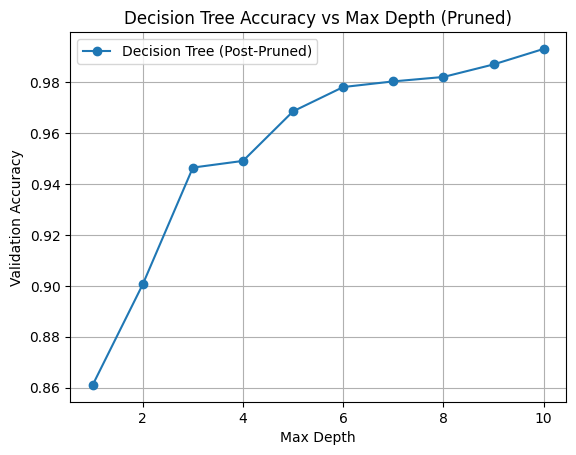

In [ ]:
depths = range(1, 11)
tree_acc = []

for d in depths:
    model = DecisionTree(max_depth=d)
    model.train(X_train.values, y_train.values)
    predictions = model.predict(X_train.values)
    acc = np.mean(predictions == y_train)

    print(f"[Decision Tree] Max Depth: {d} -> Validation Accuracy (after pruning): {acc:.4f}")
    tree_acc.append(acc)

plt.plot(depths, tree_acc, marker='o', label='Decision Tree (Post-Pruned)')
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Decision Tree Accuracy vs Max Depth (Pruned)")
plt.grid(True)
plt.legend()
plt.show()

# Training on best Hyperparameters

In [ ]:
best_depth = 5

model = DecisionTree(max_depth=best_depth)
model.train(X_train.values, y_train.values)
y_pred = model.predict(X_test.values)
y_prob = model.predict_prob(X_test.values)[:, 1]

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.9679076895339404


# Result Evaluation

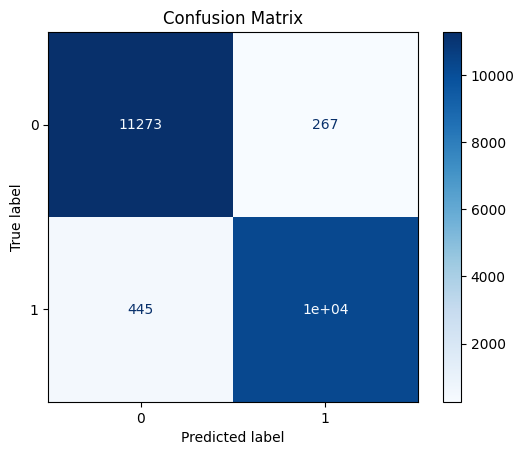

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

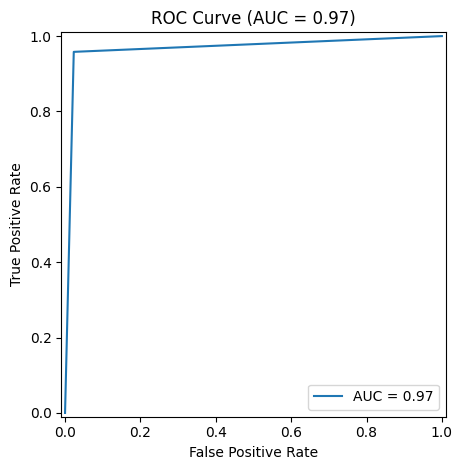

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
plt.tight_layout()
plt.show()

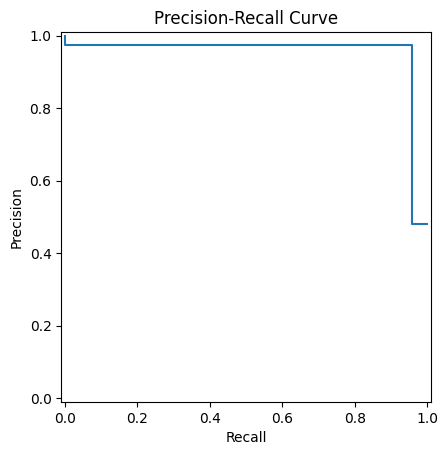

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0,0.962024,0.976863,0.969387,11540.000000
1,0.974494,0.958200,0.966278,10646.000000
accuracy,0.967908,0.967908,0.967908,0.967908
macro avg,0.968259,0.967532,0.967833,22186.000000
weighted avg,0.968008,0.967908,0.967895,22186.000000
